In [1]:
# import libraries
import os
from os.path import isfile, isdir, join
import numpy as np
from datetime import datetime, date
import time
from dateutil.relativedelta import relativedelta
from bs4 import BeautifulSoup
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from IPython.display import display
from zipfile import ZipFile
import pickle
import unicodedata
import pytz
from joblib import Parallel, delayed
import shutil
import random
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Quandl
!pip install quandl
import quandl
quandl.ApiConfig.api_key = '2MxCLy_zrKRvSsxCWs_v'

# # IEX
# !pip install pyEX
# import pyEX
# iex_token = 'pk_91a7b3bd3ab04ebc9ea84fb78aa25fd5'
# client = pyEX.Client(api_token=iex_token, version='stable')

# Alpha Vantage
!pip install alpha_vantage
import alpha_vantage
from alpha_vantage.timeseries import TimeSeries
av_token = '3AWPS6G8YY4BIRPH'

# Yahoo Finance
!pip install yfinance
import yfinance as yf

# pandas
import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

# signal for timing out an execution
import signal as signal_
class TimeoutException(Exception):   # Custom exception class
    pass
def timeout_handler(signum, frame):   # Custom signal handler
    raise TimeoutException
signal_.signal(signal_.SIGALRM, timeout_handler)



AttributeError: module 'signal' has no attribute 'SIGALRM'

In [2]:
# log
def log(msg):
    now = datetime.strftime(datetime.now(tz=pytz.timezone('Hongkong')), '%Y-%m-%d %H:%M:%S')
    print(f'[{now}] {msg}')
    
# pickle
def save_pkl(obj, filename):
    pickle.dump(obj, open(filename, 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
    return
def load_pkl(filename):
    return pickle.load(open(filename, 'rb'))

def get_size(path='.'):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            # skip if it is symbolic link
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)
    return total_size

def dl_txt(txt):
    with open(f'text.txt', 'w') as f:
        f.write(txt)
        f.close()
    return

fig_num = 0
def new_plot():
    global fig_num
    fig_num += 1
    plt.figure(fig_num)
    
# function to remove any rows/columns with all NaN
def df_drop_na(df):
    df = df.loc[lambda x: x.notnull().sum(axis=1) > 0]
    df = df[df.notnull().sum(axis=0).loc[lambda x: x>0].index.tolist()]
    return df

def align_index(dfs):
    for i in range(len(dfs)):
        if i==0:
            idx, col = dfs[i].index, dfs[i].columns
        else:
            idx, col = idx & dfs[i].index, col & dfs[i].columns
    idx, col = idx.sort_values().tolist(), col.sort_values().tolist()
    new_dfs = tuple([df.reindex(index=idx, columns=col) for df in list(dfs)])
    return new_dfs

In [3]:
# params
params = dict()
params['start_date'] = '2009-01-01'
params['end_date'] = '2018-03-27'
params['start_datetime'] = datetime.strptime(params['start_date'], '%Y-%m-%d')
params['end_datetime'] = datetime.strptime(params['end_date'], '%Y-%m-%d')

# Stock univierse and S&P500 historical constituents

In [4]:
# download tables from wiki
wiki_tbl_list = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
curr_cons = wiki_tbl_list[0] # current constituents
hist_changes = wiki_tbl_list[1] # historical changes in constituents
display(curr_cons.head())
display(hist_changes.head())

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,AOS,A. O. Smith,reports,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
3,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981


Date  Added                       Removed  \
                Date Ticker              Security  Ticker   
0      April 4, 2022    CPT                Camden    PBCT   
1      March 2, 2022    MOH     Molina Healthcare    INFO   
2  February 15, 2022   NDSN               Nordson    XLNX   
3   February 3, 2022    NaN                   NaN     GPS   
4   February 2, 2022    CEG  Constellation Energy     NaN   

                              \
                    Security   
0  People's United Financial   
1                 IHS Markit   
2                     Xilinx   
3                        Gap   
4                        NaN   

                                              Reason  
                                              Reason  
0  S&P 500 constituent M&T Bank Corp. acquired Pe...  
1  S&P 500 constituent S&P Global Inc. acquired I...  
2  S&P 500 constituent Advanced Micro Devices acq...  
3                   Market capitalization change.[9]  
4  S&P 500 and 100 constituent Exelon Corp. spun ...

In [5]:
'''
Cleansing the historical changes table
'''

# format columns
hist_changes.columns = ['_'.join(sorted(set(x))).lower() for x in hist_changes.columns]
hist_changes['date'] = pd.to_datetime(hist_changes['date'])
hist_changes['date'] = hist_changes.date + np.timedelta64(-1,'D') # subtract 1 day for ease of backward constituents reconciliation
hist_changes['added_ticker'] = hist_changes['added_ticker'].fillna('').apply(lambda x: x.replace('.','-'))
hist_changes['removed_ticker'] = hist_changes['removed_ticker'].fillna('').apply(lambda x: x.replace('.','-'))
curr_cons['Symbol'] = curr_cons['Symbol'].fillna('').apply(lambda x: x.replace('.','-'))

# save the raw version
hist_changes_raw = hist_changes.copy()

# separate into "add" entries and "remove" entries, and then concat into single table
add_df = hist_changes[['date','added_ticker']].rename(columns={'added_ticker':'symbol'})
add_df['action'] = 'add'
remove_df = hist_changes[['date','removed_ticker']].rename(columns={'removed_ticker':'symbol'})
remove_df['action'] = 'remove'
hist_changes = pd.concat([add_df, remove_df], axis=0).reset_index(drop=True)

# remove NA entries
hist_changes = hist_changes[(hist_changes['symbol'].notnull()) & (hist_changes['symbol']!='')]
assert hist_changes.isnull().sum().sum() == 0

display(curr_cons.head())
display(hist_changes.head())

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,AOS,A. O. Smith,reports,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
3,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981


,date,symbol,action
0,2022-04-03,CPT,add
1,2022-03-01,MOH,add
2,2022-02-14,NDSN,add
4,2022-02-01,CEG,add
5,2021-12-19,SBNY,add


,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABT,ACAS,ACE,ACN,ADBE,ADI,ADM,ADP,ADS,ADSK,ADT,AEE,AEP,AES,AET,AFL,AGN,AIG,AIV,AIZ,AJG,AKAM,AKS,ALB,ALGN,ALK,ALL,ALLE,ALTR,ALXN,AMAT,AMD,AME,AMG,AMGN,AMP,AMT,AMZN,AN,ANDV,ANF,ANR,ANSS,ANTM,AON,AOS,APA,APC,APD,APH,APOL,APTV,ARE,ARG,ARNC,ATI,ATVI,AVB,AVGO,AVP,AVY,AWK,AXP,AYE,AYI,AZO,BA,BAC,BALL,BAX,BBBY,BBWI,BBY,BCR,BDX,BEAM,BEN,BF-B,BHF,BIG,BIIB,BJS,BK,BKNG,BKR,BLK,BMC,BMS,BMY,BRCM,BRK-B,BSX,BTU,BWA,BXLT,BXP,C,CA,CAG,CAH,CAM,CAT,CB,CBE,CBOE,CBRE,CCE,CCI,CCL,CDNS,CEG,CELG,CEPH,CERN,CF,CFG,CFN,CHD,CHK,CHRW,CHTR,CI,CIEN,CINF,CL,CLF,CLX,CMA,CMCSA,CMCSK,CME,CMG,CMI,CMS,CNC,CNP,CNX,COF,COL,COO,COP,COST,COTY,COV,CPB,CPGX,CPRI,CPWR,CRM,CSC,CSCO,CSRA,CSX,CTAS,CTRA,CTSH,CTX,CTXS,CVC,CVG,CVH,CVS,CVX,CXO,D,DAL,DD,DE,DELL,DF,DFS,DG,DGX,DHI,DHR,DIS,DISH,DLR,DLTR,DNB,DNR,DO,DOV,DOW,DPS,DRE,DRI,DTE,DTV,DUK,DV,DVA,DVN,DWDP,DXC,DYN,EA,EBAY,ECL,ED,EFX,EIX,EK,EL,EMC,EMN,EMR,ENDP,EOG,EP,EQIX,EQR,EQT,ES,ESRX,ESS,ESV,ETFC,ETN,ETR,EVHC,EW,EXC,EXPD,EXPE,EXR,F,FAST,FB,FBHS,FCX,FDO,FDX,FE,FFIV,FHN,FII,FIS,FISV,FITB,FL,FLIR,FLR,FLS,FMC,FOSL,FOX,FOXA,FRT,FRX,FSLR,FTI,FTR,FTV,GAS,GD,GE,GENZ,GGP,GHC,GILD,GIS,GL,GLW,GM,GMCR,GME,GNW,GOOG,GOOGL,GPC,GPN,GPS,GR,GRMN,GS,GT,GWW,HAL,HAR,HAS,HBAN,HBI,HCA,HCBK,HD,HES,HIG,HII,HLT,HNZ,HOG,HOLX,HON,HOT,HP,HPE,HPQ,HRB,HRL,HSIC,HSP,HST,HSY,HUM,IBM,ICE,IDXX,IFF,IGT,ILMN,INCY,INFO,INTC,INTU,IP,IPG,IPGP,IQV,IRM,ISRG,IT,ITT,ITW,IVZ,J,JBHT,JBL,JCI,JCP,JDSU,JEF,JNJ,JNPR,JNS,JNY,JOY,JPM,JWN,K,KBH,KEY,KG,KHC,KIM,KLAC,KMB,KMI,KMX,KO,KR,KRFT,KSS,KSU,L,LEG,LEN,LH,LHX,LIFE,LIN,LKQ,LLL,LLTC,LLY,LM,LMT,LNC,LNT,LO,LOW,LRCX,LSI,LUMN,LUV,LVLT,LXK,LYB,M,MA,MAA,MAC,MAR,MAS,MAT,MBI,MCD,MCHP,MCK,MCO,MDLZ,MDT,MEE,MET,MFE,MGM,MHK,MHS,MI,MIL,MJN,MKC,MLM,MMC,MMI,MMM,MNK,MNST,MO,MOLX,MON,MOS,MPC,MRK,MRO,MS,MSFT,MSI,MTB,MTD,MU,MUR,MWW,NAVI,NBL,NBR,NCLH,NDAQ,NE,NEE,NEM,NFLX,NFX,NI,NKE,NKTR,NLOK,NLSN,NOC,NOV,NOVL,NRG,NSC,NSM,NTAP,NTRS,NUE,NVDA,NVLS,NWL,NWS,NWSA,NYT,NYX,O,ODP,OI,OKE,OMC,ORCL,ORLY,OXY,PARA,PAYX,PBCT,PBI,PCAR,PCG,PCL,PCP,PCS,PDCO,PEAK,PEG,PEP,PETM,PFE,PFG,PG,PGN,PGR,PH,PHM,PKG,PKI,PLD,PLL,PM,PNC,PNR,PNW,POM,PPG,PPL,PRGO,PRU,PSA,PSX,PTV,PVH,PWR,PXD,PYPL,Q,QCOM,QEP,QRVO,R,RAI,RCL,RDC,RE,REG,REGN,RF,RHI,RHT,RIG,RJF,RL,RMD,ROK,ROP,ROST,RRC,RRD,RSG,RSH,RTN,RTX,RX,S,SAI,SBAC,SBUX,SCG,SCHW,SE,SEE,SGP,SHLD,SHW,SIAL,SIG,SII,SIVB,SJM,SLB,SLE,SLG,SLM,SNA,SNDK,SNI,SNPS,SO,SPG,SPGI,SPLS,SRCL,SRE,STI,STJ,STR,STT,STX,STZ,SUN,SVU,SWK,SWKS,SWN,SWY,SYF,SYK,SYY,T,TAP,TDC,TDG,TE,TEG,TEL,TER,TFC,TGNA,TGT,THC,TIE,TIF,TJX,TLAB,TMO,TPR,TRIP,TROW,TRV,TSCO,TSN,TSS,TT,TTWO,TWC,TWX,TXN,TXT,TYC,UA,UAA,UAL,UDR,UHS,ULTA,UNH,UNM,UNP,UPS,URBN,URI,USB,V,VAR,VFC,VIAB,VLO,VMC,VNO,VRSK,VRSN,VRTX,VTR,VTRS,VZ,WAT,WBA,WBD,WDC,WEC,WELL,WFC,WFM,WFR,WHR,WIN,WM,WMB,WMT,WPX,WRK,WTW,WU,WY,WYN,WYNN,X,XEC,XEL,XL,XLNX,XOM,XRAY,XRX,XTO,XYL,YHOO,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2009-01-01,True,True,False,False,True,False,True,True,True,True,False,True,True,True,True,False,True,False,True,True,True,True,True,True,True,True,True,False,True,True,False,False,False,True,False,True,False,True,True,False,False,True,True,True,True,True,True,True,False,False,True,True,False,True,True,True,True,True,True,False,False,False,True,False,True,False,True,True,False,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,False,True,True,True,True,True,True,True,Fal

[2022-05-13 19:34:53] Shape of historical constituents: (3373, 676)


Text(0.5, 1.0, 'Distribution of stock life span (days)')

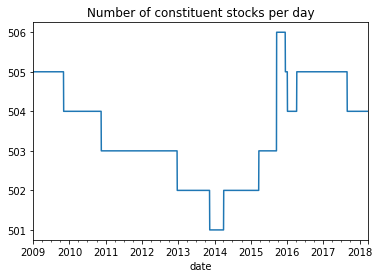

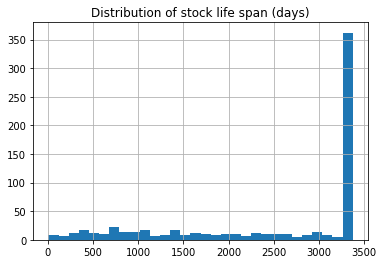

In [6]:
'''
Generate the historical constituents table (1 snapshot per day)
'''

# define total stock universe
all_stocks = sorted(set(curr_cons['Symbol'].tolist() + hist_changes[hist_changes['date']>=params['start_date']]['symbol'].tolist()))

# generate a table of historical constituents
# rows as all dates in the study preiod; columns as all stocks ever existed in S&P500 since the start of study period
# the cell value True/False denoting whether the stock is within S&P500 on that date
hist_cons = []
cons = [x in curr_cons['Symbol'].tolist() for x in all_stocks]
today = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
n_days = (today - params['start_datetime']).days + 1
for i in range(n_days):
    date = today + relativedelta(days=-i)
    actions = hist_changes[hist_changes['date']==date]
    if i > 0 and len(actions) > 0:
        for i in range(len(actions)):
            symbol = actions.iloc[i,:]['symbol']
            action = actions.iloc[i,:]['action']
            if action=='add':
                cons[all_stocks.index(symbol)] = False
            elif action=='remove':
                cons[all_stocks.index(symbol)] = True
    hist_cons.append([date] + cons.copy())
hist_cons = pd.DataFrame(hist_cons, columns=['date'] + all_stocks)

# filter dates to within study period
hist_cons = hist_cons \
            .loc[lambda x: (x.date >= params['start_date']) & (x.date <= params['end_date'])] \
            .set_index('date') \
            .sort_index()

# filter stocks to within study period
stocks = hist_cons.sum(axis=0).loc[lambda x: x>0].index.tolist()
hist_cons = hist_cons[stocks]
display(hist_cons.head())
log(f'Shape of historical constituents: {hist_cons.shape}')

# plot for DQ check
new_plot()
hist_cons.sum(axis=1).plot()
plt.title('Number of constituent stocks per day')
new_plot()
hist_cons.sum(axis=0).hist(bins=30)
plt.title('Distribution of stock life span (days)')

# Quandl data

[2022-05-13 19:35:35] Downloaded 2009 price data
[2022-05-13 19:36:13] Downloaded 2010 price data
[2022-05-13 19:36:52] Downloaded 2011 price data
[2022-05-13 19:37:31] Downloaded 2012 price data
[2022-05-13 19:38:10] Downloaded 2013 price data
[2022-05-13 19:38:49] Downloaded 2014 price data
[2022-05-13 19:39:29] Downloaded 2015 price data
[2022-05-13 19:40:07] Downloaded 2016 price data
[2022-05-13 19:40:44] Downloaded 2017 price data
[2022-05-13 19:40:52] Downloaded 2018 price data
[2022-05-13 19:40:53] Number of missing stocks: 55
[2022-05-13 19:40:53] List of missing stocks: AYE, BALL, BBWI, BF-B, BJS, BKR, BMC, BRK-B, CBE, CEG, CEPH, CPRI, CTRA, CTX, CVH, EK, EP, GENZ, GL, GR, HNZ, J, JEF, KG, LHX, LIN, LUMN, MEE, MFE, MHS, MI, MOLX, NLOK, NOVL, NVLS, NYX, PARA, PCS, PEAK, PGN, PTV, RTX, RX, SAI, SGP, SII, SLE, TFC, TIE, TLAB, TT, VTRS, WBD, WFR, XTO
[2022-05-13 19:40:53] Shape of return is (2323, 621)
[2022-05-13 19:40:53] Min date: 2009-01-02 00:00:00, Max date: 2018-03-27 00:0

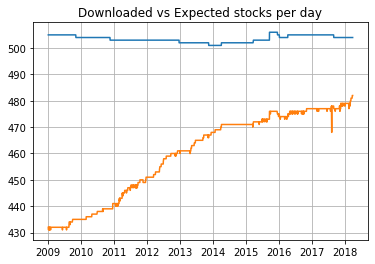

In [7]:
'''
Use Quandl WIKI API to get all historical price (only up to 27 Mar 2018)
'''
raw_ret = []
for yr in hist_cons.index.year.unique().tolist():
    df = quandl.get_table('WIKI/PRICES', 
                            ticker = ','.join(hist_cons.columns.tolist()), 
                            qopts = { 'columns': ['ticker', 'date', 'adj_close'] }, 
                            date = { 'gte': f'{yr}-01-01', 'lte':f'{yr}-12-31' }, 
                            paginate=True)
    log(f'Downloaded {yr} price data')
    raw_ret.append(df)
raw_ret = pd.concat(raw_ret)

# convert to date x stock format
ret = raw_ret.pivot(index='date', columns='ticker', values='adj_close')
ret.index = pd.to_datetime(ret.index)
ret = ret.sort_index()
ret = ret[sorted(ret.columns.tolist())]

# remove market holidays
ret = ret.loc[lambda x: ~x.index.isin(['2017-04-14'])]

# mask against historical constituents
msk = hist_cons.reindex(index=ret.index, columns=ret.columns)
ret = ret.mask(~msk)

# align trading days across return and hist_cons
hist_cons = hist_cons.reindex(ret.index)

# compare number of stocks per day
new_plot()
plt.plot(hist_cons.sum(axis=1))
plt.plot(ret.notnull().sum(axis=1))
plt.grid()
plt.title('Downloaded vs Expected stocks per day')

# list down the missing stocks
missing_stocks = [x for x in hist_cons.columns.tolist() if x not in ret.columns.tolist()]
log(f'Number of missing stocks: {len(missing_stocks)}')
log(f'List of missing stocks: {", ".join(missing_stocks)}')

# DQ
log(f'Shape of return is {ret.shape}')
log(f'Min date: {ret.index.min()}, Max date: {ret.index.max()}')

# Yahoo data

[2022-05-13 19:41:03] Shape of missing_df: (76, 4)


,stock,start,end,diff
42,MMM,2017-11-10,2018-03-27,137
21,DYN,2009-01-02,2009-12-17,349
55,Q,2009-01-02,2011-03-30,817
46,NSM,2009-01-02,2011-09-22,993
41,MMI,2009-01-02,2012-05-18,1232


<AxesSubplot:>

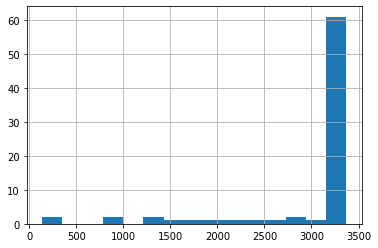

In [8]:
# list of stock and date missing from Quandl
missing = []
for stock in hist_cons.columns:
    if stock not in ret.columns:
        missing.append((stock, str(ret.index.min())[:10], str(ret.index.max())[:10]))
    else:
        date_list = hist_cons[stock].loc[lambda x: x==True].index.tolist()
        missing_date_list = ret[stock].loc[lambda x: (x.index.isin(date_list)) & (x.isnull())].index.tolist()
        if len(missing_date_list) >= 10:
            missing.append((stock, str(min(missing_date_list))[:10], str(max(missing_date_list))[:10]))
missing_df = pd.DataFrame(missing, columns=['stock','start','end']).assign(diff=lambda x: (pd.to_datetime(x.end)-pd.to_datetime(x.start)).dt.days)
log(f'Shape of missing_df: {missing_df.shape}')
display(missing_df.sort_values('diff').head())
display(missing_df['diff'].hist(bins=15))

In [9]:
'''
Get missing price data from Yahoo Finance
'''
ret_yf = []
for stock, start, end in missing:
    df = yf.download(stock, start=start, end=end, progress=False) \
            .reset_index() \
            .assign(stock = stock) \
            .rename(columns={'Date':'date', 'Adj Close':'adj_close'}) \
            .loc[:,['date','stock','adj_close']] \
            .reset_index(drop=True)
    log(f'{stock}: start={start}, end={end}, records={df.shape[0]}')
    ret_yf.append(df)
ret_yf = pd.concat(ret_yf)
ret_yf = ret_yf.pivot(index='date', columns='stock', values='adj_close')
ret_yf.index = pd.to_datetime(ret_yf.index)
ret_yf = ret_yf.sort_index()
ret_yf = ret_yf[sorted(ret_yf.columns.tolist())]

[2022-05-13 19:41:04] AA: start=2009-01-02, end=2016-10-31, records=1971
[2022-05-13 19:41:05] ANDV: start=2009-01-02, end=2017-08-02, records=2160
[2022-05-13 19:41:05] APTV: start=2009-01-02, end=2017-12-07, records=1523
[2022-05-13 19:41:06] AYE: start=2009-01-02, end=2018-03-27, records=1505
[2022-05-13 19:41:06] BALL: start=2009-01-02, end=2018-03-27, records=2323
[2022-05-13 19:41:07] BBWI: start=2009-01-02, end=2018-03-27, records=2323
[2022-05-13 19:41:08] BF-B: start=2009-01-02, end=2018-03-27, records=2323

1 Failed download:
- BJS: No data found for this date range, symbol may be delisted
[2022-05-13 19:41:08] BJS: start=2009-01-02, end=2018-03-27, records=0
[2022-05-13 19:41:08] BKNG: start=2009-01-02, end=2018-03-07, records=2309
[2022-05-13 19:41:09] BKR: start=2009-01-02, end=2018-03-27, records=2323
[2022-05-13 19:41:09] BMC: start=2009-01-02, end=2018-03-27, records=1452
[2022-05-13 19:41:10] BRK-B: start=2009-01-02, end=2018-03-27, records=2323
[2022-05-13 19:41:10] C

[2022-05-13 19:41:38] Number of missing stocks: 14
[2022-05-13 19:41:38] List of missing stocks: BJS, CEG, CEPH, CTX, CVH, EK, GENZ, MHS, NOVL, NVLS, PCS, PGN, SAI, XTO
[2022-05-13 19:41:38] Shape of return is (2323, 662)
[2022-05-13 19:41:38] Min date: 2009-01-02 00:00:00, Max date: 2018-03-27 00:00:00


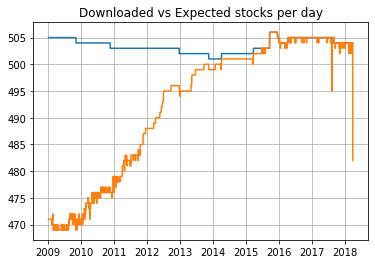

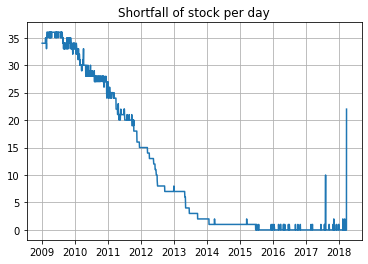

In [10]:
# add extra price from yahoo
for stock in ret_yf.columns.tolist():
    if stock not in ret.columns.tolist():
        ret[stock] = np.nan
    replace_idx = ret.loc[lambda x: x[stock].isnull()].index.intersection(ret_yf.loc[lambda x: x[stock].notnull()].index)
    ret.loc[replace_idx, stock] = ret_yf.loc[replace_idx, stock]
ret = ret[sorted(ret.columns.tolist())]
msk = hist_cons.reindex(index=ret.index, columns=ret.columns)
ret = ret.mask(~msk)


# compare number of stocks per day
new_plot()
plt.plot(hist_cons.sum(axis=1))
plt.plot(ret.notnull().sum(axis=1))
plt.grid()
plt.title('Downloaded vs Expected stocks per day')
new_plot()
plt.plot(hist_cons.sum(axis=1)-ret.notnull().sum(axis=1))
plt.grid()
plt.title('Shortfall of stock per day')

# list down the missing stocks
missing_stocks = [x for x in hist_cons.columns.tolist() if x not in ret.columns.tolist()]
log(f'Number of missing stocks: {len(missing_stocks)}')
log(f'List of missing stocks: {", ".join(missing_stocks)}')

# DQ
log(f'Shape of return is {ret.shape}')
log(f'Min date: {ret.index.min()}, Max date: {ret.index.max()}')

# Alpha Vantage data

[2022-05-13 19:41:49] Shape of missing_df: (38, 4)


,stock,start,end,diff
10,DYN,2009-01-02,2009-12-17,349
32,SII,2009-01-02,2010-02-19,413
30,RX,2009-01-02,2010-02-25,419
1,AYE,2009-02-23,2010-12-31,676
28,PTV,2009-01-02,2010-11-16,683


<AxesSubplot:>

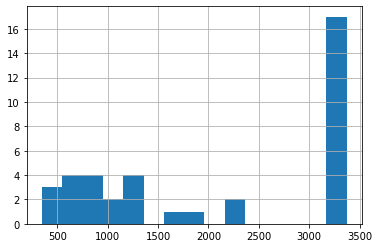

In [11]:
# list of stock and date missing from Quandl & Yahoo
missing = []
for stock in hist_cons.columns:
    if stock not in ret.columns:
        missing.append((stock, str(ret.index.min())[:10], str(ret.index.max())[:10]))
    else:
        date_list = hist_cons[stock].loc[lambda x: x==True].index.tolist()
        missing_date_list = ret[stock].loc[lambda x: (x.index.isin(date_list)) & (x.isnull())].index.tolist()
        if len(missing_date_list) >= 10:
            missing.append((stock, str(min(missing_date_list))[:10], str(max(missing_date_list))[:10]))
missing_df = pd.DataFrame(missing, columns=['stock','start','end']).assign(diff=lambda x: (pd.to_datetime(x.end)-pd.to_datetime(x.start)).dt.days)
log(f'Shape of missing_df: {missing_df.shape}')
display(missing_df.sort_values('diff').head())
display(missing_df['diff'].hist(bins=15))

In [12]:
'''
Get missing price data from Alpha Vantage
'''
ret_av = []
ts = TimeSeries(key=av_token, output_format='pandas')
for stock, start, end in missing:
    try:
        df, _ = ts.get_daily(symbol=stock, outputsize='full')
        df = df \
            .assign(stock=stock) \
            .rename(columns={'4. close':'close'}) \
            .reset_index() \
            .loc[:,['date','stock','close']] \
            .assign(date = lambda x: pd.to_datetime(x.date))
        log(f'{stock}: start={start}, end={end}, records={df.shape[0]}')
        ret_av.append(df)
        time.sleep(12)
    except:
        time.sleep(12)
        continue
ret_av = pd.concat(ret_av)
ret_av = ret_av.pivot(index='date', columns='stock', values='close')
ret_av.index = pd.to_datetime(ret_av.index)
ret_av = ret_av.sort_index()
ret_av = ret_av[sorted(ret_av.columns.tolist())]

[2022-05-13 19:41:51] APTV: start=2009-01-02, end=2017-12-07, records=2638
[2022-05-13 19:42:06] AYE: start=2009-02-23, end=2010-12-31, records=1241
[2022-05-13 19:42:20] BJS: start=2009-01-02, end=2018-03-27, records=1098
[2022-05-13 19:42:44] CEG: start=2009-01-02, end=2018-03-27, records=70
[2022-05-13 19:43:10] CFN: start=2009-01-02, end=2015-03-17, records=1401
[2022-05-13 19:43:23] CPRI: start=2009-01-02, end=2018-03-27, records=2619
[2022-05-13 19:43:37] CTX: start=2009-01-02, end=2018-03-27, records=1605
[2022-05-13 19:43:50] CVH: start=2009-01-02, end=2018-03-27, records=1713
[2022-05-13 19:44:02] DYN: start=2009-01-02, end=2009-12-17, records=417
[2022-05-13 19:44:53] IQV: start=2009-01-02, end=2017-11-14, records=2270
[2022-05-13 19:45:06] KG: start=2009-01-02, end=2010-12-16, records=7
[2022-05-13 19:45:19] LIFE: start=2009-01-02, end=2014-01-23, records=1768
[2022-05-13 19:45:44] MFE: start=2009-01-02, end=2011-02-25, records=1050
[2022-05-13 19:45:57] MHS: start=2009-01-0

[2022-05-13 19:50:01] Number of missing stocks: 4
[2022-05-13 19:50:01] List of missing stocks: CEPH, EK, GENZ, NOVL
[2022-05-13 19:50:01] Shape of return is (2323, 672)
[2022-05-13 19:50:01] Min date: 2009-01-02 00:00:00, Max date: 2018-03-27 00:00:00


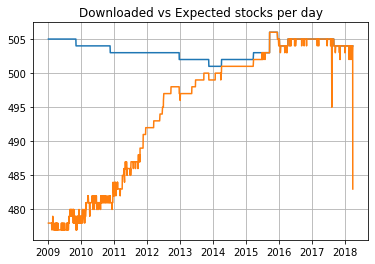

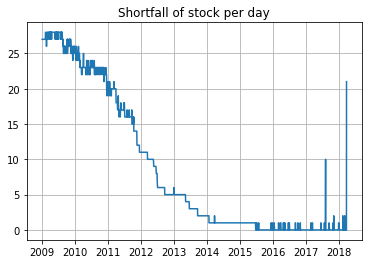

In [13]:
# add extra price from AV
for stock in ret_av.columns.tolist():
    if stock not in ret.columns.tolist():
        ret[stock] = np.nan
    replace_idx = ret.loc[lambda x: x[stock].isnull()].index.intersection(ret_av.loc[lambda x: x[stock].notnull()].index)
    ret.loc[replace_idx, stock] = ret_av.loc[replace_idx, stock]
ret = ret[sorted(ret.columns.tolist())]
msk = hist_cons.reindex(index=ret.index, columns=ret.columns)
ret = ret.mask(~msk)

# compare number of stocks per day
new_plot()
plt.plot(hist_cons.sum(axis=1))
plt.plot(ret.notnull().sum(axis=1))
plt.grid()
plt.title('Downloaded vs Expected stocks per day')
new_plot()
plt.plot(hist_cons.sum(axis=1)-ret.notnull().sum(axis=1))
plt.grid()
plt.title('Shortfall of stock per day')

# list down the missing stocks
missing_stocks = [x for x in hist_cons.columns.tolist() if x not in ret.columns.tolist()]
log(f'Number of missing stocks: {len(missing_stocks)}')
log(f'List of missing stocks: {", ".join(missing_stocks)}')

# DQ
log(f'Shape of return is {ret.shape}')
log(f'Min date: {ret.index.min()}, Max date: {ret.index.max()}')

# Final price check

,stock,ratio
533,RX,0.021739
644,WFR,0.115970
110,CBE,0.450304
38,AMD,0.621610
149,COV,0.714286
396,MEE,0.723229
277,GR,0.955605
542,SGP,0.995261
63,ATVI,0.998457


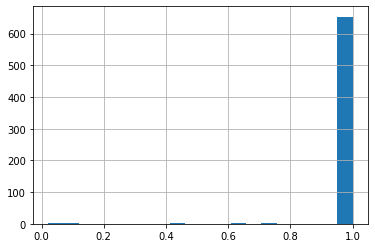

In [14]:
# check stocks that does not populate all days in life span
df = []
for stock in ret.columns.tolist():
    s = ret[stock].loc[lambda x: x.notnull()].index
    min_dt, max_dt = s.min(), s.max()
    date_span = ret[stock].loc[lambda x: (x.index >= min_dt) & (x.index <= max_dt)].shape[0]
    date_count = ret[stock].notnull().sum()
    df.append((stock, date_count/date_span))
df = pd.DataFrame(df, columns=['stock','ratio'])
df.ratio.hist(bins=20)
display(df.loc[lambda x: x.ratio < 0.999].sort_values('ratio'))

444


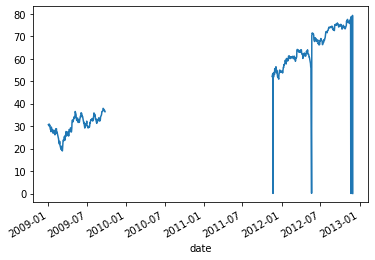

In [15]:
# visualise single stock to check continuity
stock = 'CBE'
ret[stock].plot()
print(ret[stock].count())
# display(ret[stock].loc[lambda x: (x.notnull()) & (x.index.year==2010)])

In [16]:
# remove low data quality stock
rm = ['RX','WFR']
ret = ret.drop(rm, axis=1)

0.001   -0.128185
0.999    0.143704
dtype: float64

ticker,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABT,ACAS,ACE,ACN,ADBE,ADI,ADM,ADP,ADS,ADSK,ADT,AEE,AEP,AES,AET,AFL,AGN,AIG,AIV,AIZ,AJG,AKAM,AKS,ALB,ALGN,ALK,ALL,ALLE,ALTR,ALXN,AMAT,AMD,AME,AMG,AMGN,AMP,AMT,AMZN,AN,ANDV,ANF,ANR,ANSS,ANTM,AON,AOS,APA,APC,APD,APH,APOL,APTV,ARE,ARG,ARNC,ATI,ATVI,AVB,AVGO,AVP,AVY,AWK,AXP,AYE,AYI,AZO,BA,BAC,BALL,BAX,BBBY,BBWI,BBY,BCR,BDX,BEAM,BEN,BF-B,BHF,BIG,BIIB,BJS,BK,BKNG,BKR,BLK,BMC,BMS,BMY,BRCM,BRK-B,BSX,BTU,BWA,BXLT,BXP,C,CA,CAG,CAH,CAM,CAT,CB,CBE,CBOE,CBRE,CCE,CCI,CCL,CDNS,CEG,CELG,CERN,CF,CFG,CFN,CHD,CHK,CHRW,CHTR,CI,CIEN,CINF,CL,CLF,CLX,CMA,CMCSA,CMCSK,CME,CMG,CMI,CMS,CNC,CNP,CNX,COF,COL,COO,COP,COST,COTY,COV,CPB,CPGX,CPRI,CPWR,CRM,CSC,CSCO,CSRA,CSX,CTAS,CTRA,CTSH,CTX,CTXS,CVC,CVG,CVH,CVS,CVX,CXO,D,DAL,DD,DE,DELL,DF,DFS,DG,DGX,DHI,DHR,DIS,DISH,DLR,DLTR,DNB,DNR,DO,DOV,DOW,DPS,DRE,DRI,DTE,DTV,DUK,DV,DVA,DVN,DWDP,DXC,DYN,EA,EBAY,ECL,ED,EFX,EIX,EL,EMC,EMN,EMR,ENDP,EOG,EP,EQIX,EQR,EQT,ES,ESRX,ESS,ESV,ETFC,ETN,ETR,EVHC,EW,EXC,EXPD,EXPE,EXR,F,FAST,FB,FBHS,FCX,FDO,FDX,FE,FFIV,FHN,FII,FIS,FISV,FITB,FL,FLIR,FLR,FLS,FMC,FOSL,FOX,FOXA,FRT,FRX,FSLR,FTI,FTR,FTV,GAS,GD,GE,GGP,GHC,GILD,GIS,GL,GLW,GM,GMCR,GME,GNW,GOOG,GOOGL,GPC,GPN,GPS,GR,GRMN,GS,GT,GWW,HAL,HAR,HAS,HBAN,HBI,HCA,HCBK,HD,HES,HIG,HII,HLT,HNZ,HOG,HOLX,HON,HOT,HP,HPE,HPQ,HRB,HRL,HSIC,HSP,HST,HSY,HUM,IBM,ICE,IDXX,IFF,IGT,ILMN,INCY,INFO,INTC,INTU,IP,IPG,IPGP,IQV,IRM,ISRG,IT,ITT,ITW,IVZ,J,JBHT,JBL,JCI,JCP,JDSU,JEF,JNJ,JNPR,JNS,JNY,JOY,JPM,JWN,K,KBH,KEY,KG,KHC,KIM,KLAC,KMB,KMI,KMX,KO,KR,KRFT,KSS,KSU,L,LEG,LEN,LH,LHX,LIFE,LIN,LKQ,LLL,LLTC,LLY,LM,LMT,LNC,LNT,LO,LOW,LRCX,LSI,LUMN,LUV,LVLT,LXK,LYB,M,MA,MAA,MAC,MAR,MAS,MAT,MBI,MCD,MCHP,MCK,MCO,MDLZ,MDT,MEE,MET,MFE,MGM,MHK,MHS,MI,MIL,MJN,MKC,MLM,MMC,MMI,MMM,MNK,MNST,MO,MOLX,MON,MOS,MPC,MRK,MRO,MS,MSFT,MSI,MTB,MTD,MU,MUR,MWW,NAVI,NBL,NBR,NCLH,NDAQ,NE,NEE,NEM,NFLX,NFX,NI,NKE,NKTR,NLOK,NLSN,NOC,NOV,NRG,NSC,NSM,NTAP,NTRS,NUE,NVDA,NVLS,NWL,NWS,NWSA,NYT,NYX,O,ODP,OI,OKE,OMC,ORCL,ORLY,OXY,PARA,PAYX,PBCT,PBI,PCAR,PCG,PCL,PCP,PCS,PDCO,PEAK,PEG,PEP,PETM,PFE,PFG,PG,PGN,PGR,PH,PHM,PKG,PKI,PLD,PLL,PM,PNC,PNR,PNW,POM,PPG,PPL,PRGO,PRU,PSA,PSX,PTV,PVH,PWR,PXD,PYPL,Q,QCOM,QEP,QRVO,R,RAI,RCL,RDC,RE,REG,REGN,RF,RHI,RHT,RIG,RJF,RL,RMD,ROK,ROP,ROST,RRC,RRD,RSG,RSH,RTN,RTX,S,SAI,SBAC,SBUX,SCG,SCHW,SE,SEE,SGP,SHLD,SHW,SIAL,SIG,SII,SIVB,SJM,SLB,SLE,SLG,SLM,SNA,SNDK,SNI,SNPS,SO,SPG,SPGI,SPLS,SRCL,SRE,STI,STJ,STR,STT,STX,STZ,SUN,SVU,SWK,SWKS,SWN,SWY,SYF,SYK,SYY,T,TAP,TDC,TDG,TE,TEG,TEL,TER,TFC,TGNA,TGT,THC,TIE,TIF,TJX,TLAB,TMO,TPR,TRIP,TROW,TRV,TSCO,TSN,TSS,TT,TTWO,TWC,TWX,TXN,TXT,TYC,UA,UAA,UAL,UDR,UHS,ULTA,UNH,UNM,UNP,UPS,URBN,URI,USB,V,VAR,VFC,VIAB,VLO,VMC,VNO,VRSK,VRSN,VRTX,VTR,VTRS,VZ,WAT,WBA,WBD,WDC,WEC,WELL,WFC,WFM,WHR,WIN,WM,WMB,WMT,WPX,WRK,WTW,WU,WY,WYN,WYNN,X,XEC,XEL,XL,XLNX,XOM,XRAY,XRX,XTO,XYL,YHOO,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2009-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

<AxesSubplot:>

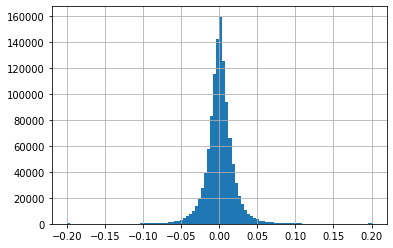

In [17]:
# convert price to return
msk = hist_cons.reindex(index=ret.index, columns=ret.columns)
ret = ret \
        .sort_index() \
        .pct_change() \
        .mask(~msk)

# check extreme values
s = pd.Series(ret.values.flatten())
s = s.loc[lambda x: x.notnull()]
q = 0.001
display(s.quantile([q, 1-q]))

# clipping
ratio_thsld = 2
clip_thsld = 0.2
ret.loc[:,:] = np.select([ret > ratio_thsld-1, ret < 1/ratio_thsld-1, ret > clip_thsld, ret < -clip_thsld, True], [0, 0, clip_thsld, -clip_thsld, ret])
display(ret.head())
pd.Series(ret.values.flatten()).hist(bins=100)

# Calculate Beta and Excess Returns

In [18]:
# download SPY
df = yf.download('SPY', start=params['start_date'], end=params['end_date'], progress=False) \
        .reset_index() \
        .assign(stock = 'SPY') \
        .rename(columns={'Date':'date', 'Adj Close':'adj_close'}) \
        .loc[:,['date','stock','adj_close']] \
        .reset_index(drop=True)
spy = df.pivot(index='date', columns='stock', values='adj_close')
spy.index = pd.to_datetime(spy.index)
spy = spy.sort_index().pct_change()

# align stock and SPY dates
dates = (spy['SPY'].loc[lambda x: x.notnull()].index & ret.index).sort_values()
ret = ret.reindex(index=dates)
spy = spy.reindex(index=dates)

log(f'Shape of SPY: {spy.shape}')
log(f'Number of nulls of SPY: {spy.SPY.isnull().sum()}')

# add SPY to returns table
ret = ret.merge(spy, how='inner', left_index=True, right_index=True)

[2022-05-13 19:50:05] Shape of SPY: (2321, 1)
[2022-05-13 19:50:05] Number of nulls of SPY: 0


In [19]:
def get_beta(ret, n_day, window):
    '''ret is a returns table with last columns as SPY'''
    
    # convert return to n-day horizon
    ret = ret.rolling(n_day).sum()
    
    # individual stock volatility
    stacked_vols = ret.rolling(window, min_periods=window//2).std() \
        .clip(0.01, 3) \
        .stack().reset_index() \
        .set_axis(['date', 'stock', 'stock_vol'], axis=1)
    
    # correlation between stock and market
    stacked_corrs = ret['SPY'] \
        .rolling(window, min_periods=window//2) \
        .corr(other=ret, pairwise=False) \
        .stack().reset_index() \
        .set_axis(['date', 'stock', 'correl'], axis=1)
        
    # beta calculation
    beta = stacked_vols \
         .merge(stacked_corrs, how='inner', on=['date', 'stock']) \
         .set_index('date')
    market_vol = pd.DataFrame(beta.loc[lambda x: x.stock=='SPY']['stock_vol']).rename(columns={'stock_vol':'market_vol'})
    beta = beta.merge(market_vol, how='inner', left_index=True, right_index=True)
    beta['beta'] = beta['correl'] * beta['stock_vol'] / beta['market_vol']
    beta = beta.loc[lambda x: x.stock!='SPY']
    beta = beta.reset_index().pivot('date','stock','beta')
    return beta
    
    
def get_excess_return(ret, beta, n_day):
    '''ret is a returns table with last columns as SPY'''
    
    # convert return to n-day horizon
    ret = ret.rolling(n_day).sum()
    
    # calculate excess return
    beta = beta.merge(ret['SPY'], how='inner', left_index=True, right_index=True)
    pred_ret = beta.drop('SPY', axis=1).multiply(beta['SPY'], axis=0)
    ret, pred_ret = align_index([ret, pred_ret])
    exret = ret - pred_ret
    return ret, exret

In [20]:
# calculate beta for all investment horizons
horizons = {'1d':1, '3d':3, '1w':5, '2w':10, '1m':21, '3m':21*3, '6m':21*6, '9m':21*9, '12m':21*12}
betas = {}
for h in horizons:
    betas[h] = get_beta(ret=ret, n_day=horizons[h], window=252)
    
# get 1-day excess return
ret, exret = get_excess_return(ret=ret, beta=betas['1d'], n_day=horizons['1d'])

<AxesSubplot:xlabel='date'>

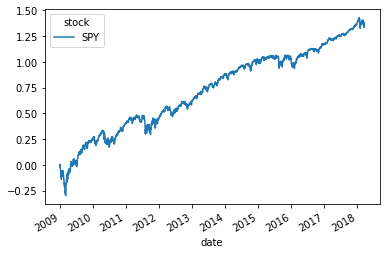

In [21]:
# check market PnL
spy.cumsum().plot()

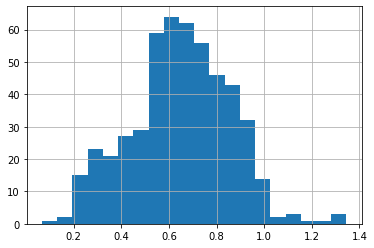

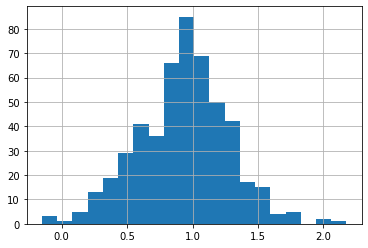

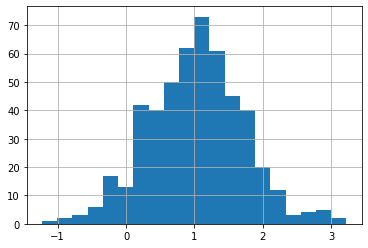

In [22]:
# check beta distribution
for h in ['1d','1w','1m']:
    new_plot()
    betas[h].iloc[-1].hist(bins=20)

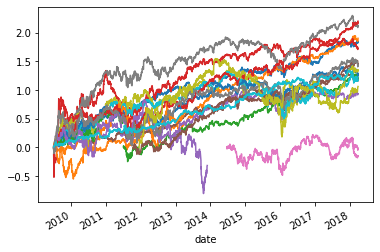

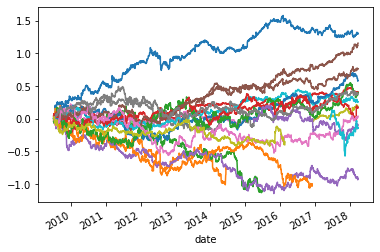

In [23]:
# cumulative returns before removing market return
sample_stock = random.sample(ret.columns.tolist(),20)
new_plot()
for c in sample_stock:
    ret[c].cumsum().plot()
    
# cumulative returns after removing market return
sample_stock = random.sample(exret.columns.tolist(),20)
new_plot()
for c in sample_stock:
    exret[c].cumsum().plot()

<AxesSubplot:>

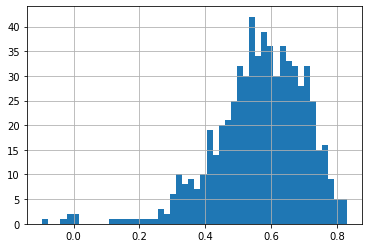

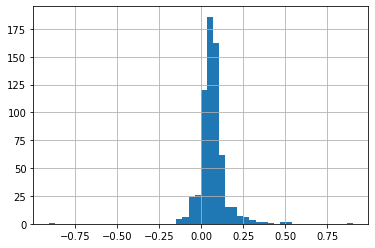

In [24]:
# check excess return is uncorrelated with market return
corr = []
for stock in ret:
    corr.append(pd.concat([ret[stock], spy.SPY], axis=1).dropna().corr().iloc[0,1])
new_plot()
pd.Series(corr).hist(bins=50)

corr = []
for stock in exret:
    corr.append(pd.concat([exret[stock], spy.SPY], axis=1).dropna().corr().iloc[0,1])
new_plot()
pd.Series(corr).hist(bins=50)

In [25]:
# export
ret.to_csv('ret.csv')
exret.to_csv('exret.csv')
save_pkl(spy, 'spy')
save_pkl(betas, 'betas')